# Text Classification in Cross-Validation using PAC Algorithm

## Import Libraries

In [1]:
import re
import unicodedata
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from lime import lime_text
from sklearn import metrics
from nltk.corpus import stopwords
from sklearn import preprocessing
from nltk.tokenize import word_tokenize 
from sklearn.pipeline import make_pipeline
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

from sklearn.linear_model import PassiveAggressiveClassifier

## Set Hyparameters

In [2]:
C=1.0
tol=0.001

nfold=10

number_of_feature = 7000

dataset_path = "../input/indian-parliament/rajyasabha_questions_and_answers.xlsx"
sheet_name="rajyasabha_questions_and_answer"

text="question_description"
review="ministry"

language="english"

## Load Dataset

In [3]:
df = pd.read_excel(dataset_path, sheet_name=sheet_name)
print(f'Found {len(df)} texts.')

print(f'{df[review].isnull().sum()} document(s) with no classification removed')
df=df[pd.notnull(df[review])]

print(f'{df[text].isnull().sum()} document(s) with no text removed')
df=df[pd.notnull(df[text])]

le = preprocessing.LabelEncoder()
le.fit(df[review])
df[review]=le.transform(df[review])

classes = [int(c) for c in df[review]]
documents = [d for d in df[text]]

###### Print dataset ###################
df = df[[text,review ]]
df.columns = ['sentiment', 'review']
df.head(3)

Found 89095 texts.
2 document(s) with no classification removed
6 document(s) with no text removed


,sentiment,review
0,(a) whether Government is aware that there is ...,6
1,(a) whether in order to capitalize on the lull...,6
2,(a) whether the Chinese businessmen packed of ...,6


## Class Distribution Diagram

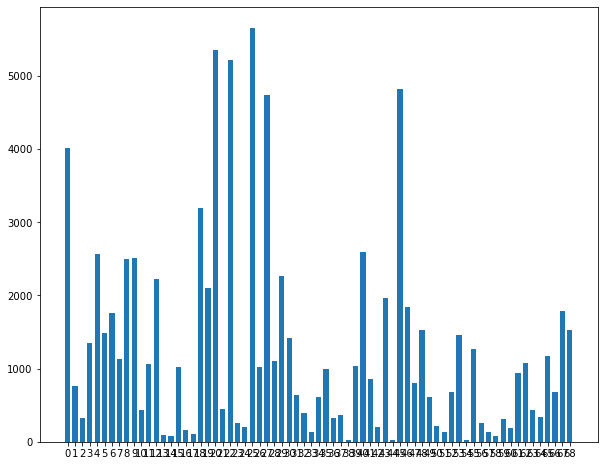

In [4]:
y = np.bincount(classes)
x = np.arange(len(y))
fig, ax = plt.subplots(figsize=(10,8))
plt.bar(x, y,width=0.7)
ax.set_xticks(x)
ax.set_aspect('auto')
plt.show()

## Define Preprocessor

In [5]:
def preprocessor(text):
    text = re.sub('<[^>]*>', ' ', str(text))
    text=re.sub('\d+',' ',str(text))
    text=re.sub('[ﾫﾻ]','',str(text))
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           str(text))
    text = (re.sub('[\W]+', ' ', text.lower()) + ' ' +
            ' '.join(emoticons).replace('-', ''))
    return text

def strip_accents(text):
    
    try:
        text = unicode(text, 'utf-8')
    except (TypeError, NameError): # unicode is a default on python 3 
        pass
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)

stop=set(stopwords.words(language))

def tokenizer_porter(text):
    word_tokens = word_tokenize(text)
    stemmer = SnowballStemmer(language, ignore_stopwords=True)
    return [stemmer.stem(word) for word in word_tokens]

## Define Infogain Function

In [6]:
def information_gain(X, y):

    def _calIg():
        entropy_x_set = 0
        entropy_x_not_set = 0
        for c in classCnt:
            probs = classCnt[c] / float(featureTot)
            entropy_x_set = entropy_x_set - probs * np.log(probs)
            probs = (classTotCnt[c] - classCnt[c]) / float(tot - featureTot)
            entropy_x_not_set = entropy_x_not_set - probs * np.log(probs)
        for c in classTotCnt:
            if c not in classCnt:
                probs = classTotCnt[c] / float(tot - featureTot)
                entropy_x_not_set = entropy_x_not_set - probs * np.log(probs)
        return entropy_before - ((featureTot / float(tot)) * entropy_x_set
                             +  ((tot - featureTot) / float(tot)) * entropy_x_not_set)

    tot = X.shape[0]
    classTotCnt = {}
    entropy_before = 0
    for i in y:
        if i not in classTotCnt:
            classTotCnt[i] = 1
        else:
            classTotCnt[i] = classTotCnt[i] + 1
    for c in classTotCnt:
        probs = classTotCnt[c] / float(tot)
        entropy_before = entropy_before - probs * np.log(probs)

    nz = X.T.nonzero()
    pre = 0
    classCnt = {}
    featureTot = 0
    information_gain = []
    for i in range(0, len(nz[0])):
        if (i != 0 and nz[0][i] != pre):
            for notappear in range(pre+1, nz[0][i]):
                information_gain.append(0)
            ig = _calIg()
            information_gain.append(ig)
            pre = nz[0][i]
            classCnt = {}
            featureTot = 0
        featureTot = featureTot + 1
        yclass = y[nz[1][i]]
        if yclass not in classCnt:
            classCnt[yclass] = 1
        else:
            classCnt[yclass] = classCnt[yclass] + 1
    ig = _calIg()
    information_gain.append(ig)

    return np.asarray(information_gain)

#https://stackoverflow.com/questions/25462407/fast-information-gain-computation

## Cross-Validation Pipeline

Feature trovati: 10538
Feature usati: 7000
--------------- Fold:  1 ---------------------

Accuracy: 0.8
Detail:
              precision    recall  f1-score   support

           0       0.82      0.87      0.85       402
           1       0.91      0.84      0.88        76
           2       0.85      0.88      0.86        32
           3       0.88      0.92      0.90       134
           4       0.92      0.94      0.93       257
           5       0.85      0.90      0.87       149
           6       0.57      0.59      0.58       176
           7       0.46      0.33      0.38       113
           8       0.83      0.86      0.85       249
           9       0.83      0.87      0.85       251
          10       0.67      0.70      0.68        43
          11       0.89      0.85      0.87       106
          12       0.84      0.85      0.84       223
          13       0.60      0.33      0.43         9
          14       0.33      0.25      0.29         8
          15       0.7

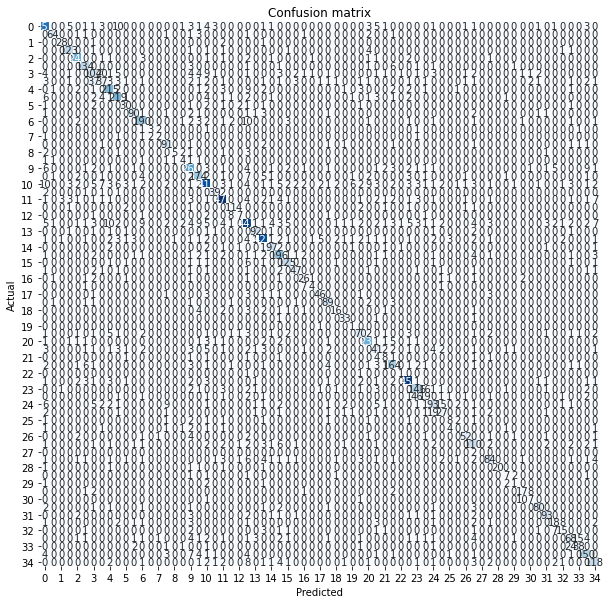

Feature trovati: 10561
Feature usati: 7000
--------------- Fold:  2 ---------------------

Accuracy: 0.8
Detail:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       402
           1       0.85      0.87      0.86        76
           2       0.83      0.91      0.87        32
           3       0.86      0.90      0.88       134
           4       0.94      0.92      0.93       257
           5       0.86      0.86      0.86       149
           6       0.58      0.63      0.60       176
           7       0.39      0.35      0.37       113
           8       0.86      0.85      0.85       249
           9       0.84      0.89      0.86       251
          10       0.71      0.74      0.73        43
          11       0.87      0.84      0.85       107
          12       0.87      0.81      0.84       223
          13       0.38      0.50      0.43        10
          14       0.50      0.50      0.50         8
          15       0.7

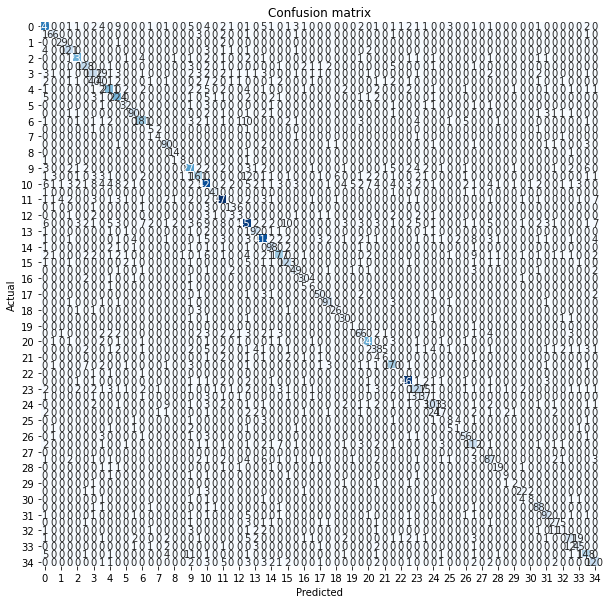

Feature trovati: 10548
Feature usati: 7000
--------------- Fold:  3 ---------------------

Accuracy: 0.79
Detail:
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       402
           1       0.92      0.92      0.92        76
           2       0.88      0.88      0.88        32
           3       0.89      0.91      0.90       135
           4       0.89      0.91      0.90       257
           5       0.85      0.85      0.85       150
           6       0.58      0.53      0.55       176
           7       0.40      0.38      0.39       113
           8       0.85      0.88      0.86       250
           9       0.80      0.86      0.83       251
          10       0.67      0.64      0.65        44
          11       0.93      0.85      0.89       106
          12       0.80      0.80      0.80       223
          13       0.33      0.20      0.25        10
          14       0.55      0.75      0.63         8
          15       0.

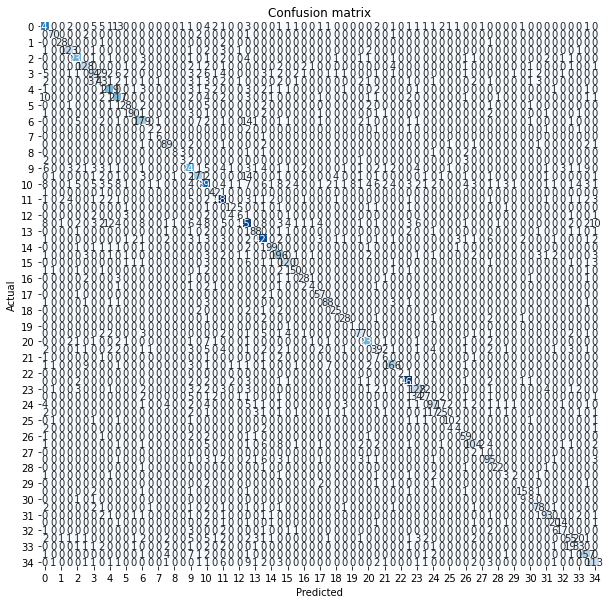

Feature trovati: 10527
Feature usati: 7000
--------------- Fold:  4 ---------------------

Accuracy: 0.8
Detail:
              precision    recall  f1-score   support

           0       0.82      0.86      0.83       402
           1       0.92      0.93      0.93        76
           2       0.78      0.88      0.82        32
           3       0.89      0.88      0.88       135
           4       0.90      0.92      0.91       257
           5       0.90      0.93      0.91       150
           6       0.58      0.53      0.55       176
           7       0.39      0.36      0.38       113
           8       0.88      0.84      0.86       250
           9       0.87      0.86      0.86       251
          10       0.73      0.61      0.67        44
          11       0.88      0.88      0.88       106
          12       0.85      0.85      0.85       223
          13       0.42      0.50      0.45        10
          14       0.45      0.56      0.50         9
          15       0.7

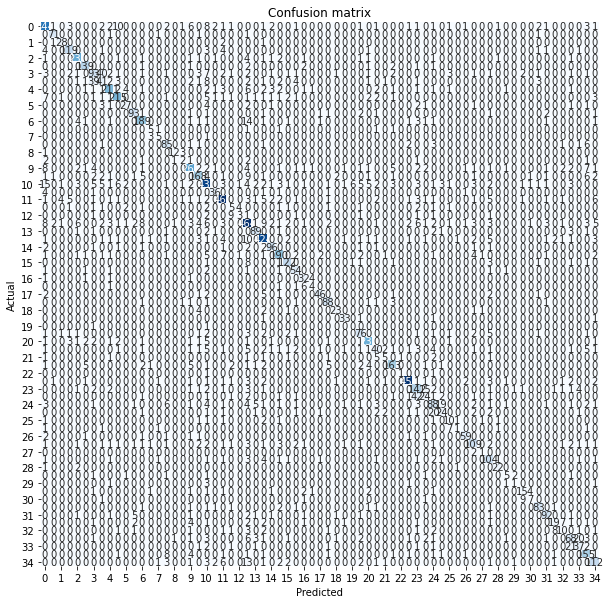

Feature trovati: 10509
Feature usati: 7000
--------------- Fold:  5 ---------------------

Accuracy: 0.8
Detail:
              precision    recall  f1-score   support

           0       0.86      0.85      0.85       402
           1       0.90      0.83      0.86        76
           2       0.77      0.84      0.81        32
           3       0.93      0.86      0.89       135
           4       0.90      0.92      0.91       257
           5       0.83      0.87      0.85       150
           6       0.58      0.61      0.60       175
           7       0.44      0.42      0.43       113
           8       0.87      0.83      0.85       249
           9       0.83      0.90      0.86       251
          10       0.79      0.59      0.68        44
          11       0.91      0.86      0.88       106
          12       0.82      0.82      0.82       223
          13       0.43      0.30      0.35        10
          14       0.20      0.12      0.15         8
          15       0.7

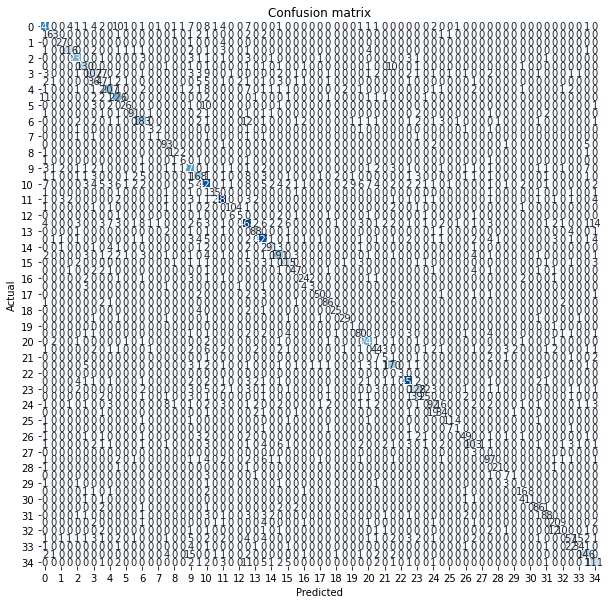

Feature trovati: 10544
Feature usati: 7000
--------------- Fold:  6 ---------------------

Accuracy: 0.79
Detail:
              precision    recall  f1-score   support

           0       0.85      0.84      0.84       402
           1       0.79      0.86      0.82        76
           2       0.68      0.82      0.74        33
           3       0.89      0.84      0.87       135
           4       0.93      0.91      0.92       257
           5       0.85      0.89      0.87       149
           6       0.58      0.62      0.60       175
           7       0.44      0.31      0.36       113
           8       0.84      0.83      0.84       249
           9       0.80      0.85      0.83       251
          10       0.62      0.59      0.60        44
          11       0.89      0.93      0.91       106
          12       0.80      0.87      0.83       223
          13       0.75      0.30      0.43        10
          14       0.40      0.25      0.31         8
          15       0.

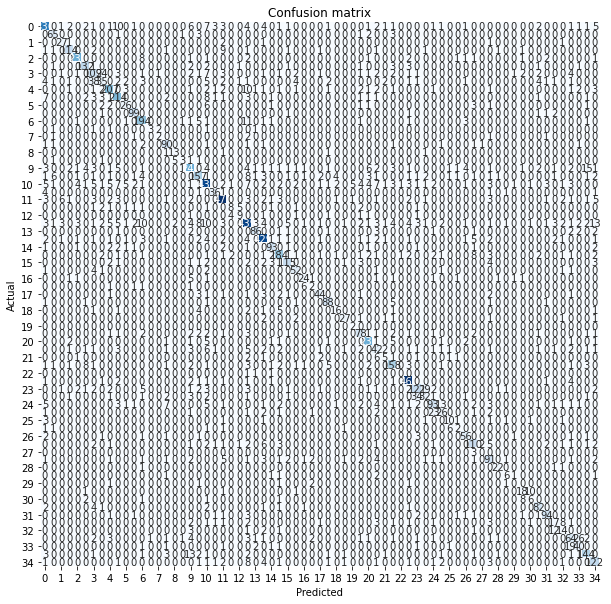

Feature trovati: 10504
Feature usati: 7000
--------------- Fold:  7 ---------------------

Accuracy: 0.8
Detail:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       402
           1       0.83      0.91      0.87        76
           2       0.88      0.88      0.88        33
           3       0.85      0.88      0.87       135
           4       0.91      0.91      0.91       257
           5       0.86      0.89      0.87       149
           6       0.61      0.57      0.59       175
           7       0.46      0.42      0.44       113
           8       0.82      0.87      0.85       249
           9       0.84      0.88      0.86       250
          10       0.64      0.64      0.64        44
          11       0.86      0.85      0.85       106
          12       0.83      0.78      0.80       224
          13       0.38      0.50      0.43        10
          14       0.29      0.25      0.27         8
          15       0.7

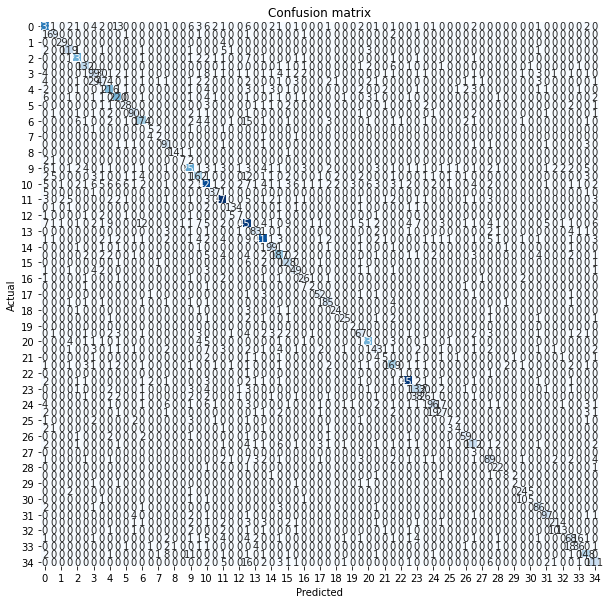

Feature trovati: 10545
Feature usati: 7000
--------------- Fold:  8 ---------------------

Accuracy: 0.79
Detail:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       401
           1       0.88      0.88      0.88        76
           2       0.84      0.97      0.90        32
           3       0.89      0.93      0.91       134
           4       0.89      0.93      0.91       257
           5       0.88      0.93      0.90       149
           6       0.54      0.61      0.57       175
           7       0.52      0.34      0.41       113
           8       0.87      0.82      0.84       249
           9       0.84      0.83      0.83       251
          10       0.61      0.75      0.67        44
          11       0.87      0.87      0.87       106
          12       0.85      0.80      0.82       223
          13       0.50      0.30      0.37        10
          14       0.14      0.12      0.13         8
          15       0.

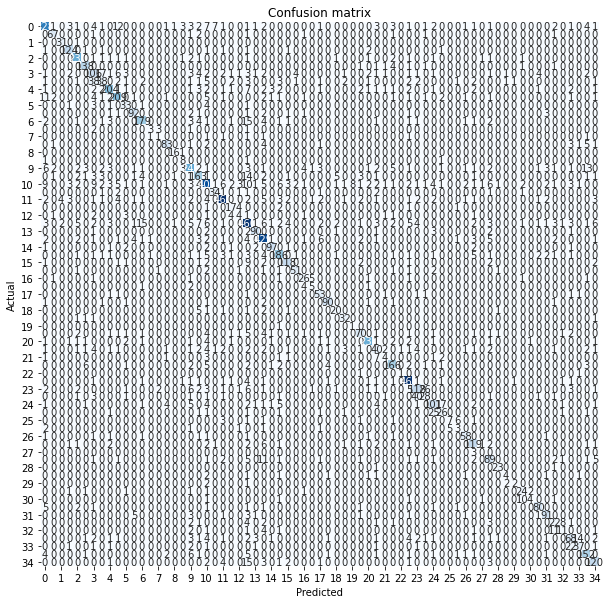

Feature trovati: 10572
Feature usati: 7000
--------------- Fold:  9 ---------------------

Accuracy: 0.8
Detail:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       401
           1       0.91      0.92      0.92        76
           2       0.82      0.84      0.83        32
           3       0.89      0.93      0.91       134
           4       0.92      0.90      0.91       256
           5       0.87      0.87      0.87       149
           6       0.59      0.59      0.59       175
           7       0.44      0.41      0.42       113
           8       0.83      0.86      0.85       249
           9       0.81      0.86      0.83       251
          10       0.71      0.61      0.66        44
          11       0.93      0.88      0.90       106
          12       0.81      0.76      0.78       223
          13       0.30      0.33      0.32         9
          14       0.30      0.38      0.33         8
          15       0.7

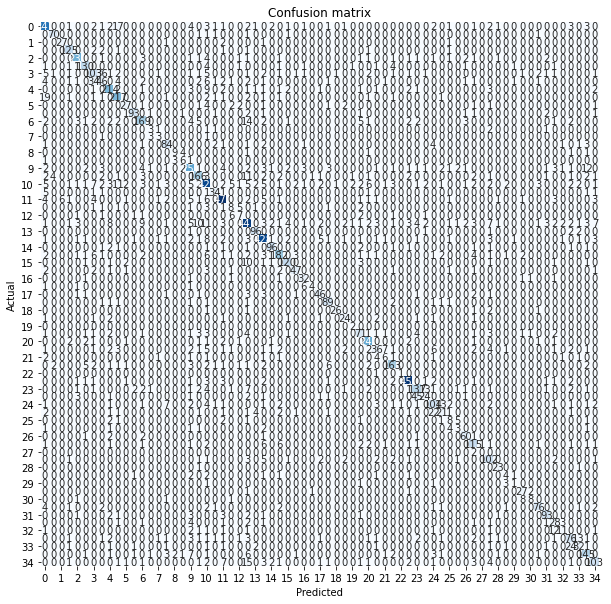

Feature trovati: 10534
Feature usati: 7000
--------------- Fold: 10 ---------------------

Accuracy: 0.8
Detail:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       402
           1       0.89      0.84      0.86        76
           2       0.88      0.94      0.91        32
           3       0.88      0.90      0.89       134
           4       0.88      0.91      0.90       256
           5       0.88      0.89      0.88       149
           6       0.60      0.58      0.59       175
           7       0.43      0.30      0.35       113
           8       0.83      0.81      0.82       249
           9       0.86      0.84      0.85       251
          10       0.80      0.65      0.72        43
          11       0.92      0.92      0.92       106
          12       0.84      0.80      0.82       223
          13       0.17      0.11      0.13         9
          14       0.42      0.62      0.50         8
          15       0.8

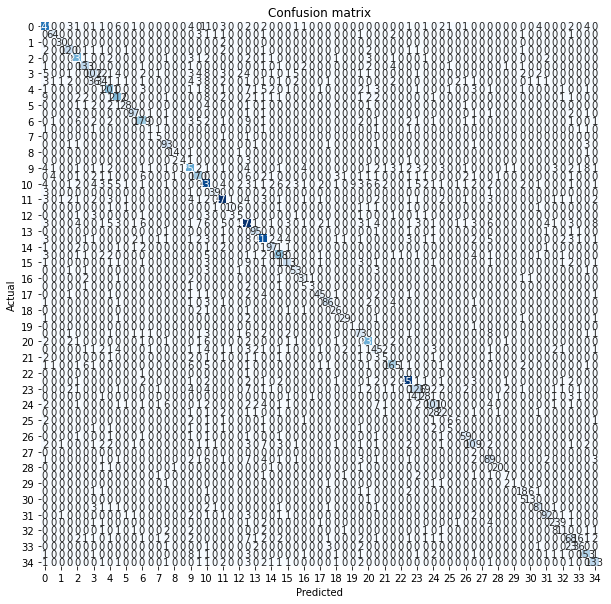

In [7]:
####### Setting up Cross-Validation #####
X=np.array(documents)
y=np.array(classes)
kfold = StratifiedKFold(n_splits=nfold,shuffle=True,random_state=1).split(X, y)

####### Define Variables for Metrics #####
accuracys = []
scores= []
metriche = np.zeros((nfold,4,len(np.unique(classes))))
target_names=list(map(str,np.unique(classes)))

####### Cross-Validation Loop ############

for k, (train, test) in enumerate(kfold):
    
   ########## Start Features Selection Procedure #########
    
    tfidf = TfidfVectorizer(strip_accents=strip_accents,
                        lowercase=False,
                        preprocessor=preprocessor,
                        tokenizer=tokenizer_porter,
                        stop_words=stop,
                        min_df = 4
                       )

    final_features = tfidf.fit_transform(X[train])
    print("Feature trovati:",final_features.toarray().shape[1])
    
    X_names=tfidf.get_feature_names()
    
    dtf_features = pd.DataFrame()
    IG_score = information_gain(final_features, y[train])
    dtf_features = dtf_features.append(pd.DataFrame({"feature":X_names, "IG_score":IG_score}))
    dtf_features = dtf_features.sort_values(["IG_score"], ascending=[False])
    dtf_features = dtf_features.head(number_of_feature)
    X_names = dtf_features["feature"].unique().tolist()

    
    tfidf = TfidfVectorizer(strip_accents=strip_accents,
                        lowercase=False,
                        preprocessor=preprocessor,
                        tokenizer=tokenizer_porter,
                        stop_words=stop,
                        min_df = 4,
                        vocabulary=X_names
                       )

    final_features = tfidf.fit_transform(X[train])
    
    print("Feature usati:",final_features.toarray().shape[1])
    
   ########## End Features Selection Procedure #########

   ########## Define Pipeline ########
    
    pipe_lr = make_pipeline(
                        tfidf,
                        PassiveAggressiveClassifier(C=C,tol=tol)
                        )
    
   #######################################

    pipe_lr.fit(X[train], y[train])
    y_pred=pipe_lr.predict(X[test])
    #y_prob=pipe_lr.predict_proba(X[test])

    
    ####### Compute Accuracy ##########
    accuracy = pipe_lr.score(X[test], y[test])
    accuracys.append(accuracy)
    
    ####### Compute Precision,Recall,F-Score ############
    score=precision_recall_fscore_support(y_true=y[test], y_pred=y_pred, average="weighted")
    scores.append(score[0:3])
    
    print('--------------- Fold: %2d ---------------------'% (k+1))
    print()
    print("Accuracy:",  round(accuracy,2))
    print("Detail:")
    print(metrics.classification_report(y[test], y_pred))
    
    dizionario=metrics.classification_report(y[test], y_pred, target_names=target_names,output_dict=True)
    for k_d,(m_id, m_info) in enumerate(dizionario.items()):
        if k_d<len(np.unique(classes)):
            for j_d,key in enumerate(m_info):
                metriche[k,j_d,k_d]=m_info[key]
        else:
            break
    
    ## Plot confusion matrix
    conf_mat = confusion_matrix(y[test], y_pred)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d', ax=ax, cbar=False,cmap=plt.cm.Blues)
    ax.set(xlabel="Predicted", ylabel="Actual", xticklabels=target_names, 
           yticklabels=target_names, title="Confusion matrix")
    plt.yticks(rotation=0)
    
    print()
    
    plt.show()
    
    ## select observation
    #i = 0
    #txt_instance = X[test][i]
    ## check true value and predicted value
    #print("True:", y[test][i], "--> Pred:", y_pred[i], "| Prob:", round(np.max(y_prob[i]),2))
    ## show explanation
    #explainer = lime_text.LimeTextExplainer(class_names=target_names)
    #explained = explainer.explain_instance(txt_instance, 
                 #pipe_lr.predict_proba, num_features=6,top_labels=2)
    #explained.show_in_notebook(text=txt_instance, predict_proba=False)

    
arr = np.array(scores)

## Results Output

In [8]:
print("Overall results of the cross-validation procedure")
print()
print("Level 1")
print()

print('\nCV accuracy: %.2f +/- %.2f max: %.2f' % (np.mean(accuracys)*100, np.std(accuracys)*100,np.max(accuracys)*100))
print('\nCV precision: %.2f +/- %.2f max: %.2f' % (np.mean(arr[:,0])*100, np.std(arr[:,0])*100,np.max(arr[:,0])*100))
print('\nCV recall: %.2f +/- %.2f max: %.2f' % (np.mean(arr[:,1])*100, np.std(arr[:,1])*100,np.max(arr[:,1])*100))
print('\nCV f1: %.2f +/- %.2f max: %.2f' % (np.mean(arr[:,2])*100, np.std(arr[:,2])*100,np.max(arr[:,2])*100))

print()
print("Level 2")
print()
print(f"{'Class':^7} | {'precision':^9}{'':^6} | {'recall':^10}{'':^5} | {'f1-measure':^6}{'':^5} | {'support':^9}")
for i in range(len(np.unique(classes))):
    print(f"{i :^7} | {np.mean(metriche[:,0,i])*100:^5.2f} +/-{np.std(metriche[:,0,i])*100:^6.2f} | {np.mean(metriche[:,1,i])*100:^5.2f} +/-{np.std(metriche[:,1,i])*100:^6.2f} | {np.mean(metriche[:,2,i])*100:^5.2f} +/-{np.std(metriche[:,2,i])*100:^6.2f} | {np.mean(metriche[:,3,i]):^9.2f}")

Overall results of the cross-validation procedure

Level 1


CV accuracy: 79.63 +/- 0.41 max: 80.26

CV precision: 79.38 +/- 0.41 max: 80.10

CV recall: 79.63 +/- 0.41 max: 80.26

CV f1: 79.38 +/- 0.41 max: 80.07

Level 2

 Class  | precision       |   recall        | f1-measure      |  support 
   0    | 83.74 +/- 1.49  | 85.12 +/- 1.59  | 84.40 +/- 0.88  |  401.80  
   1    | 88.07 +/- 4.13  | 88.03 +/- 3.65  | 87.98 +/- 3.11  |   76.00  
   2    | 81.93 +/- 6.06  | 88.22 +/- 4.28  | 84.89 +/- 4.78  |   32.20  
   3    | 88.52 +/- 1.93  | 89.52 +/- 2.72  | 88.98 +/- 1.49  |  134.50  
   4    | 90.80 +/- 1.86  | 91.78 +/- 0.98  | 91.27 +/- 1.04  |  256.80  
   5    | 86.26 +/- 1.86  | 88.68 +/- 2.41  | 87.45 +/- 1.97  |  149.30  
   6    | 58.01 +/- 1.87  | 58.56 +/- 3.30  | 58.21 +/- 1.70  |  175.40  
   7    | 43.75 +/- 3.68  | 36.11 +/- 4.07  | 39.34 +/- 2.68  |  113.00  
   8    | 84.97 +/- 1.85  | 84.47 +/- 2.12  | 84.69 +/- 1.15  |  249.20  
   9    | 83.12 +/- 2.09  | 86.61 +/-